# test_joint_hmc

这个 notebook 内嵌 `hmc_scripts/run_joint_hmc.py` 的完整逻辑，不调用外部脚本。
默认设置：4 probes (dspl/lens/sne/quasar), clean-only inference, target_accept_prob=0.99。


In [1]:
import os
os.environ.setdefault("HDF5_USE_FILE_LOCKING", "FALSE")

from pathlib import Path
import sys

workdir = Path.cwd()
if (workdir / 'hmc_scripts').exists() is False:
    workdir = Path('/users/tianli/LensedUniverse')
os.chdir(workdir)
if str(workdir) not in sys.path:
    sys.path.insert(0, str(workdir))

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, init_to_value
from jax import random
import arviz as az

from slcosmo import tool
from hmc_scripts.corner_utils import select_corner_vars, make_overlay_corner

USE_X64 = os.environ.get("SLCOSMO_USE_X64", "0").strip().lower() in {"1", "true", "yes", "y", "on"}
jax.config.update("jax_enable_x64", USE_X64)
if USE_X64:
    numpyro.enable_x64()
if any(d.platform == "gpu" for d in jax.devices()):
    numpyro.set_platform("gpu")
else:
    numpyro.set_platform("cpu")
print(f"[INFO] Precision mode: {'FP64' if USE_X64 else 'FP32'}", flush=True)

SEED = 42
rng_np = np.random.default_rng(SEED)
np.random.seed(SEED)

RUN_NOISY_INFERENCE = False
RESULT_DIR = Path(os.environ.get("SLCOSMO_RESULT_DIR", "/mnt/lustre/tianli/LensedUniverse_result"))
RESULT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = Path(os.environ.get("SLCOSMO_FIG_DIR", "result"))
FIG_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path(os.environ.get("SLCOSMO_DATA_DIR", str(workdir / "data")))


def step(message):
    print(f"[STEP] {message}", flush=True)


cosmo_true = {"Omegam": 0.32, "Omegak": 0.0, "w0": -1.0, "wa": 0.0, "h0": 70.0}
cosmo_prior = {
    "w0_up": 0.0,   "w0_low": -2.0,
    "wa_up": 2.0,   "wa_low": -2.0,
    "omegak_up": 1.0, "omegak_low": -1.0,
    "h0_up": 80.0,  "h0_low": 60.0,
    "omegam_up": 0.5, "omegam_low": 0.1,
}
DSPL_TARGET = 500
PHOTO_FRAC_ZS2 = 0.60

# ---------------------------
# DSPL data (clean + noisy)
# ---------------------------
step("Build DSPL clean/noisy datasets")
data_dspl = np.loadtxt(DATA_DIR / "EuclidDSPLs_1.txt")
data_dspl = data_dspl[(data_dspl[:, 5] < 0.95)]

zl_dspl  = data_dspl[:, 0]
zs1_dspl = data_dspl[:, 1]
zs2_true_cat = data_dspl[:, 2]

beta_err_dspl = data_dspl[:, 6]
model_vel_dspl = data_dspl[:, 11]

step(
    f"Catalog zs2<=zs1 count: {int(np.sum(zs2_true_cat <= zs1_dspl))}/"
    f"{len(zs2_true_cat)} (no pre-filter)"
)

N_all = len(zl_dspl)
if N_all > DSPL_TARGET:
    select_idx = np.sort(rng_np.choice(N_all, size=DSPL_TARGET, replace=False))
    zl_dspl = zl_dspl[select_idx]
    zs1_dspl = zs1_dspl[select_idx]
    zs2_true_cat = zs2_true_cat[select_idx]
    beta_err_dspl = beta_err_dspl[select_idx]
    model_vel_dspl = model_vel_dspl[select_idx]
N_dspl = len(zl_dspl)

n_photo = int(round(PHOTO_FRAC_ZS2 * N_dspl))
n_photo = max(0, min(n_photo, N_dspl))
is_photo = np.zeros(N_dspl, dtype=bool)
if n_photo > 0:
    photo_idx = rng_np.choice(N_dspl, size=n_photo, replace=False)
    is_photo[photo_idx] = True
step(
    f"Use {N_dspl} DSPL systems; source2 photo-z count={int(is_photo.sum())} "
    f"({float(is_photo.mean()):.2%})"
)
zs2_err = np.where(is_photo, 0.1, 1e-4)
zs2_obs = zs2_true_cat + rng_np.normal(0.0, zs2_err)

eps = 1e-3
bad = zs2_obs <= (zs1_dspl + eps)
for _ in range(20):
    if not np.any(bad):
        break
    zs2_obs[bad] = zs2_true_cat[bad] + rng_np.normal(0.0, zs2_err[bad])
    bad = zs2_obs <= (zs1_dspl + eps)
zs2_obs = np.maximum(zs2_obs, zs1_dspl + eps)

Dl1, Ds1, Dls1 = tool.compute_distances(zl_dspl, zs1_dspl, cosmo_true)
Dl2, Ds2, Dls2 = tool.compute_distances(zl_dspl, zs2_true_cat, cosmo_true)
beta_geom_dspl = Dls1 * Ds2 / (Ds1 * Dls2)

lambda_true_dspl = tool.truncated_normal(1.0, 0.05, 0.85, 1.15, N_dspl, random_state=rng_np)
lambda_err_dspl = lambda_true_dspl * 0.10

true_vel_dspl = model_vel_dspl * jnp.sqrt(lambda_true_dspl)
vel_err_dspl = 0.03 * true_vel_dspl

beta_true_dspl = tool.beta_antimst(beta_geom_dspl, mst=lambda_true_dspl)

lambda_obs_dspl_clean = lambda_true_dspl
beta_obs_dspl_clean = beta_true_dspl
zs2_use_clean = zs2_true_cat

lambda_obs_dspl_noisy = lambda_true_dspl + rng_np.normal(0.0, lambda_err_dspl)
beta_obs_dspl_noisy = tool.truncated_normal(beta_true_dspl, beta_err_dspl, 0.0, 1.0, random_state=rng_np)
zs2_use_noisy = zs2_obs


def build_dspl(lambda_obs, beta_obs, zs2_use):
    spec_mask = ~is_photo
    return {
        "zl": zl_dspl,
        "zs1": zs1_dspl,
        "zs2_cat": zs2_true_cat,
        "zs2_obs": zs2_use,
        "zs2_err": zs2_err,
        "is_photo": is_photo.astype(np.int32),
        "beta_obs": beta_obs,
        "beta_err": beta_err_dspl,
        "v_model": model_vel_dspl,
        "v_obs": true_vel_dspl,
        "v_err": vel_err_dspl,
        "lambda_err": lambda_err_dspl,
        "lambda_obs": lambda_obs,
        "zl_photo": zl_dspl[is_photo],
        "zs1_photo": zs1_dspl[is_photo],
        "zs2_obs_photo": zs2_use[is_photo],
        "zs2_err_photo": zs2_err[is_photo],
        "beta_obs_photo": beta_obs[is_photo],
        "beta_err_photo": beta_err_dspl[is_photo],
        "lambda_obs_photo": lambda_obs[is_photo],
        "lambda_err_photo": lambda_err_dspl[is_photo],
        "zl_spec": zl_dspl[spec_mask],
        "zs1_spec": zs1_dspl[spec_mask],
        "zs2_obs_spec": zs2_use[spec_mask],
        "beta_obs_spec": beta_obs[spec_mask],
        "beta_err_spec": beta_err_dspl[spec_mask],
        "lambda_obs_spec": lambda_obs[spec_mask],
        "lambda_err_spec": lambda_err_dspl[spec_mask],
    }


dspl_clean = build_dspl(lambda_obs_dspl_clean, beta_obs_dspl_clean, zs2_use_clean)
dspl_noisy = build_dspl(lambda_obs_dspl_noisy, beta_obs_dspl_noisy, zs2_use_noisy)

# ---------------------------
# Lens+kin data (clean + noisy)
# ---------------------------
step("Build lens+kinematic clean/noisy datasets")
LUT = np.load(DATA_DIR / "velocity_disp_table.npy")
N1, N2, N3, N4 = LUT.shape
thetaE_grid = np.linspace(0.5, 3.0, N1)
gamma_grid  = np.linspace(1.2, 2.8, N2)
Re_grid     = np.linspace(0.15, 3.0, N3)
beta_grid   = np.linspace(-0.5, 0.8, N4)
jampy_interp = tool.make_4d_interpolant(thetaE_grid, gamma_grid, Re_grid, beta_grid, LUT)

Euclid_GG_data = np.loadtxt(DATA_DIR / "Euclid_len.txt")
zl_lens = Euclid_GG_data[:, 0]
zs_lens = Euclid_GG_data[:, 1]
Ein_lens = Euclid_GG_data[:, 2]
re_lens = Euclid_GG_data[:, 5]

mask_lens = (Ein_lens >= 0.6) & (re_lens >= 0.25) & (re_lens <= 2.8)
zl_lens = zl_lens[mask_lens]
zs_lens = zs_lens[mask_lens]
thetaE_lens = Ein_lens[mask_lens]
re_lens = re_lens[mask_lens]

dl_lens, ds_lens, dls_lens = tool.dldsdls(zl_lens, zs_lens, cosmo_true, n=20)
N_lens = len(zl_lens)

gamma_true_lens = tool.truncated_normal(2.0, 0.2, 1.5, 2.5, N_lens, random_state=rng_np)
beta_true_lens  = tool.truncated_normal(0.0, 0.2, -0.4, 0.4, N_lens, random_state=rng_np)
vel_model_lens = jampy_interp(thetaE_lens, gamma_true_lens, re_lens, beta_true_lens) * jnp.sqrt(ds_lens / dls_lens)
lambda_true_lens = tool.truncated_normal(1.0, 0.05, 0.8, 1.2, N_lens, random_state=rng_np)
vel_true_lens = vel_model_lens * jnp.sqrt(lambda_true_lens)

theta_E_err = 0.01 * thetaE_lens
vel_err_lens = 0.10 * vel_true_lens

gamma_obs_clean = gamma_true_lens
thetaE_obs_clean = thetaE_lens
vel_obs_clean = vel_true_lens

gamma_obs_noisy = gamma_true_lens + tool.truncated_normal(0.0, 0.05, -0.2, 0.2, N_lens, random_state=rng_np)
thetaE_obs_noisy = thetaE_lens + np.random.normal(0.0, theta_E_err)
vel_obs_noisy = np.random.normal(vel_true_lens, vel_err_lens)


def build_lens(gamma_obs, theta_E_obs, vel_obs):
    return {
        "zl": zl_lens,
        "zs": zs_lens,
        "theta_E": theta_E_obs,
        "theta_E_err": theta_E_err,
        "re": re_lens,
        "gamma_obs": gamma_obs,
        "vel_obs": vel_obs,
        "vel_err": vel_err_lens,
    }

lens_clean = build_lens(gamma_obs_clean, thetaE_obs_clean, vel_obs_clean)
lens_noisy = build_lens(gamma_obs_noisy, thetaE_obs_noisy, vel_obs_noisy)

# ---------------------------
# SNe time-delay data (clean + noisy)
# ---------------------------
step("Build SNe clean/noisy datasets")
sn_data = pd.read_csv(DATA_DIR / "Euclid_150SNe.csv")
sn_data = sn_data[(sn_data["tmax"] >= 5) & (sn_data["tmax"] <= 80)]
sn_data = sn_data.nlargest(100, "tmax")
zl_sne = np.array(sn_data["zl"])
zs_sne = np.array(sn_data["z_host"])
t_delay_true_days = np.array(sn_data["tmax"])

Dl_sne, Ds_sne, Dls_sne = tool.dldsdls(zl_sne, zs_sne, cosmo_true, n=20)
Ddt_geom_sne = (1.0 + zl_sne) * Dl_sne * Ds_sne / Dls_sne

N_sne = len(zl_sne)

lambda_pop_mean = 1.0
lambda_pop_sigma = 0.05
lambda_low, lambda_high = 0.8, 1.2
lambda_true_sne = tool.truncated_normal(lambda_pop_mean, lambda_pop_sigma, lambda_low, lambda_high, N_sne, random_state=rng_np)

seconds_per_day = 86400.0
Mpc_km = tool.Mpc / 1000.0

fermat_phi_true = (tool.c_km_s * t_delay_true_days * seconds_per_day) / (Ddt_geom_sne * Mpc_km)

t_delay_true_mst = t_delay_true_days * lambda_true_sne

sigma_t_days = 1.0
sigma_phi_frac = 0.04
sigma_lambda_frac = 0.08

if True:
    t_delay_obs_clean = t_delay_true_mst.copy()
    fermat_phi_obs_clean = fermat_phi_true.copy()
    lambda_obs_clean = lambda_true_sne.copy()

    t_delay_obs_noisy = t_delay_true_mst + np.random.normal(0.0, sigma_t_days, size=N_sne)
    fermat_phi_obs_noisy = fermat_phi_true + np.random.normal(0.0, sigma_phi_frac * np.abs(fermat_phi_true))
    lambda_obs_noisy = lambda_true_sne + np.random.normal(0.0, sigma_lambda_frac * np.abs(lambda_true_sne))

lambda_err_sne = sigma_lambda_frac * np.abs(lambda_obs_clean)


def scale_phi(phi_obs):
    finite = np.isfinite(phi_obs) & (phi_obs != 0)
    if not np.any(finite):
        return phi_obs, 1.0
    median = np.median(np.abs(phi_obs[finite]))
    if (not np.isfinite(median)) or median == 0:
        return phi_obs, 1.0
    exp = int(np.round(-np.log10(median)))
    scale = 10.0 ** exp
    return phi_obs * scale, scale

fermat_phi_obs_clean_scaled, phi_scale_sne = scale_phi(fermat_phi_obs_clean)
fermat_phi_obs_noisy_scaled = fermat_phi_obs_noisy * phi_scale_sne

sne_clean = {
    "zl": zl_sne,
    "zs": zs_sne,
    "t_obs": t_delay_obs_clean,
    "phi_obs": fermat_phi_obs_clean_scaled,
    "phi_scale": phi_scale_sne,
    "lambda_obs": lambda_obs_clean,
    "lambda_err": lambda_err_sne,
}

sne_noisy = {
    "zl": zl_sne,
    "zs": zs_sne,
    "t_obs": t_delay_obs_noisy,
    "phi_obs": fermat_phi_obs_noisy_scaled,
    "phi_scale": phi_scale_sne,
    "lambda_obs": lambda_obs_noisy,
    "lambda_err": lambda_err_sne,
}

# ---------------------------
# Quasar time-delay data (clean + noisy)
# ---------------------------
step("Build quasar clean/noisy datasets")
DATA_JSON = Path("../Temp_data/static_datavectors_seed6.json")
with DATA_JSON.open("r") as f:
    quasar_blocks = json.load(f)

z_lens_list = []
z_src_list = []
t_base_list = []
t_err_list = []
block_id_list = []

for b, block in enumerate(quasar_blocks):
    z_lens = np.asarray(block["z_lens"], dtype=float)
    z_src = np.asarray(block["z_src"], dtype=float)

    td = np.asarray(block["td_measured"], dtype=float)
    td_mean = td.mean(axis=1)

    n_lens, n_td = td_mean.shape
    if n_td == 3:
        idx = np.argmax(np.abs(td_mean), axis=1)
        t_base = np.abs(td_mean[np.arange(n_lens), idx])
    else:
        t_base = np.abs(td_mean[:, 0])

    if b in (0, 1, 2):
        t_err = 0.03 * t_base
    else:
        t_err = np.full_like(t_base, 5.0)

    z_lens_list.append(z_lens)
    z_src_list.append(z_src)
    t_base_list.append(t_base)
    t_err_list.append(t_err)
    block_id_list.append(np.full(n_lens, b, dtype=int))

z_lens_q = np.concatenate(z_lens_list)
z_src_q = np.concatenate(z_src_list)
t_base_q = np.concatenate(t_base_list)
t_err_q = np.concatenate(t_err_list)
block_id_q = np.concatenate(block_id_list)

zl_j = jnp.asarray(z_lens_q)
zs_j = jnp.asarray(z_src_q)
Dl_q, Ds_q, Dls_q = tool.dldsdls(zl_j, zs_j, cosmo_true, n=20)
Ddt_geom_q = (1.0 + zl_j) * Dl_q * Ds_q / Dls_q
Ddt_geom_q = np.asarray(Ddt_geom_q)

c_km_day = tool.c_km_s * 86400.0
Mpc_km = tool.Mpc / 1000.0

phi_true_q = (c_km_day * t_base_q) / (Ddt_geom_q * Mpc_km)

phi_err_frac_by_block = {
    0: 0.02,
    1: 0.05,
    2: 0.05,
    3: 0.11,
    4: 0.11,
    5: 0.18,
    6: 0.18,
    7: 0.18,
    8: 0.18,
}

sigma_v_frac_by_block = {
    0: 0.03,
    1: 0.03,
    2: 0.03,
    3: 0.10,
    4: 0.10,
    5: 0.10,
    6: 0.10,
    7: np.nan,
    8: np.nan,
}

phi_err_frac_q = np.asarray([phi_err_frac_by_block[b] for b in block_id_q])
phi_err_q = phi_err_frac_q * np.abs(phi_true_q)

lambda_true_q = tool.truncated_normal(1.0, 0.05, 0.8, 1.2, z_lens_q.size, random_state=rng_np)

sigma_v_frac_q = np.asarray([sigma_v_frac_by_block[b] for b in block_id_q])
mst_mask_q = np.isfinite(sigma_v_frac_q)
mst_err_frac_q = 2.0 * sigma_v_frac_q
lambda_err_q = np.where(mst_mask_q, mst_err_frac_q * np.abs(lambda_true_q), 0.05)

t_true_q = t_base_q * lambda_true_q

phi_obs_q_clean = phi_true_q.copy()
phi_obs_q_noisy = phi_true_q + rng_np.normal(0.0, phi_err_q)

phi_obs_q_clean_scaled, phi_scale_q = scale_phi(phi_obs_q_clean)
phi_obs_q_noisy_scaled = phi_obs_q_noisy * phi_scale_q

lambda_obs_q_clean = lambda_true_q.copy()
lambda_obs_q_noisy = lambda_true_q + rng_np.normal(0.0, lambda_err_q)

t_obs_q_clean = t_true_q.copy()
t_obs_q_noisy = t_true_q + rng_np.normal(0.0, t_err_q)

quasar_clean = {
    "zl": z_lens_q,
    "zs": z_src_q,
    "t_obs": t_obs_q_clean,
    "t_err": t_err_q,
    "phi_obs": phi_obs_q_clean_scaled,
    "phi_err": phi_err_frac_q * np.abs(phi_obs_q_clean_scaled),
    "phi_scale": phi_scale_q,
    "lambda_obs": lambda_obs_q_clean,
    "lambda_err": lambda_err_q,
    "mst_mask": mst_mask_q,
}

quasar_noisy = {
    "zl": z_lens_q,
    "zs": z_src_q,
    "t_obs": t_obs_q_noisy,
    "t_err": t_err_q,
    "phi_obs": phi_obs_q_noisy_scaled,
    "phi_err": phi_err_frac_q * np.abs(phi_obs_q_noisy_scaled),
    "phi_scale": phi_scale_q,
    "lambda_obs": lambda_obs_q_noisy,
    "lambda_err": lambda_err_q,
    "mst_mask": mst_mask_q,
}


def head_dict(data_dict, N_use=None):
    out = {}
    for k, v in data_dict.items():
        arr = np.asarray(v)
        if arr.shape == ():
            out[k] = arr
        else:
            out[k] = arr[:N_use] if N_use is not None else arr
    return out

N_DSPL_USE = None
N_LENS_USE = None
N_SNE_USE = None
N_QUASAR_USE = None

num_warmup = 500
num_samples = 1500
num_chains = 4
chain_method = "vectorized"

step("Apply per-probe sample limits for this run mode")

dspl_clean = head_dict(dspl_clean, N_DSPL_USE)
Lens_clean = head_dict(lens_clean, N_LENS_USE)
sne_clean = head_dict(sne_clean, N_SNE_USE)
quasar_clean = head_dict(quasar_clean, N_QUASAR_USE)

dspl_noisy = head_dict(dspl_noisy, N_DSPL_USE)
Lens_noisy = head_dict(lens_noisy, N_LENS_USE)
sne_noisy = head_dict(sne_noisy, N_SNE_USE)
quasar_noisy = head_dict(quasar_noisy, N_QUASAR_USE)


def cosmology_model(kind, cosmo_prior, sample_h0=True):
    cosmo = {
        "Omegam": numpyro.sample("Omegam", dist.Uniform(cosmo_prior["omegam_low"], cosmo_prior["omegam_up"])),
        "Omegak": 0.0,
        "w0": -1.0,
        "wa": 0.0,
        "h0": 70.0,
    }
    if kind in ["wcdm", "owcdm", "waw0cdm", "owaw0cdm"]:
        cosmo["w0"] = numpyro.sample("w0", dist.Uniform(cosmo_prior["w0_low"], cosmo_prior["w0_up"]))
    if kind in ["waw0cdm", "owaw0cdm"]:
        cosmo["wa"] = numpyro.sample("wa", dist.Uniform(cosmo_prior["wa_low"], cosmo_prior["wa_up"]))
    if kind in ["owcdm", "owaw0cdm"]:
        cosmo["Omegak"] = numpyro.sample("Omegak", dist.Uniform(cosmo_prior["omegak_low"], cosmo_prior["omegak_up"]))
    if sample_h0:
        cosmo["h0"] = numpyro.sample("h0", dist.Uniform(cosmo_prior["h0_low"], cosmo_prior["h0_up"]))
    return cosmo


def joint_model(dspl_data=None, lens_data=None, sne_data=None, quasar_data=None):
    cosmo = cosmology_model("waw0cdm", cosmo_prior, sample_h0=True)

    lambda_mean = numpyro.sample("lambda_mean", dist.Uniform(0.9, 1.1))
    lambda_sigma = numpyro.sample("lambda_sigma", dist.TruncatedNormal(0.05, 0.5, low=0.0, high=0.2))

    gamma_mean = numpyro.sample("gamma_mean", dist.Uniform(1.4, 2.6))
    gamma_sigma = numpyro.sample("gamma_sigma", dist.TruncatedNormal(0.2, 0.2, low=0.0, high=0.4))

    beta_mean = numpyro.sample("beta_mean", dist.Uniform(-0.3, 0.3))
    beta_sigma = numpyro.sample("beta_sigma", dist.TruncatedNormal(0.2, 0.2, low=0.0, high=0.4))

    if dspl_data is not None:
        n_photo = int(np.asarray(dspl_data["zl_photo"]).shape[0])
        n_spec = int(np.asarray(dspl_data["zl_spec"]).shape[0])
        eps = 1e-3

        if n_photo > 0:
            zl_photo = jnp.asarray(dspl_data["zl_photo"])
            zs1_photo = jnp.asarray(dspl_data["zs1_photo"])
            zs2_obs_photo = jnp.asarray(dspl_data["zs2_obs_photo"])
            zs2_err_photo = jnp.asarray(dspl_data["zs2_err_photo"])

            Dl1_photo, Ds1_photo, Dls1_photo = tool.compute_distances(zl_photo, zs1_photo, cosmo)
            # Sample latent source redshifts only for photo-z systems; treating near-spec-z points as latent can stall NUTS at high target_accept.
            zs2_true_photo = numpyro.sample(
                "zs2_true_photo",
                dist.TruncatedNormal(zs2_obs_photo, zs2_err_photo, low=zs1_photo + eps, high=10.0).to_event(1),
            )
            Dl2_photo, Ds2_photo, Dls2_photo = tool.compute_distances(zl_photo, zs2_true_photo, cosmo)
            beta_geom_photo = Dls1_photo * Ds2_photo / (Ds1_photo * Dls2_photo)

            with numpyro.plate("dspl_photo", n_photo):
                lambda_photo = numpyro.sample("lambda_dspl_photo", dist.TruncatedNormal(lambda_mean, lambda_sigma, low=0.8, high=1.2))
                numpyro.sample("lambda_dspl_photo_like", dist.Normal(lambda_photo, dspl_data["lambda_err_photo"]), obs=dspl_data["lambda_obs_photo"])
                beta_mst_photo = tool.beta_antimst(beta_geom_photo, lambda_photo)
                numpyro.sample(
                    "beta_dspl_photo_like",
                    dist.TruncatedNormal(beta_mst_photo, dspl_data["beta_err_photo"], low=0.0, high=1.0),
                    obs=dspl_data["beta_obs_photo"],
                )

        if n_spec > 0:
            zl_spec = jnp.asarray(dspl_data["zl_spec"])
            zs1_spec = jnp.asarray(dspl_data["zs1_spec"])
            zs2_spec = jnp.asarray(dspl_data["zs2_obs_spec"])

            Dl1_spec, Ds1_spec, Dls1_spec = tool.compute_distances(zl_spec, zs1_spec, cosmo)
            Dl2_spec, Ds2_spec, Dls2_spec = tool.compute_distances(zl_spec, zs2_spec, cosmo)
            beta_geom_spec = Dls1_spec * Ds2_spec / (Ds1_spec * Dls2_spec)

            with numpyro.plate("dspl_spec", n_spec):
                lambda_spec = numpyro.sample("lambda_dspl_spec", dist.TruncatedNormal(lambda_mean, lambda_sigma, low=0.8, high=1.2))
                numpyro.sample("lambda_dspl_spec_like", dist.Normal(lambda_spec, dspl_data["lambda_err_spec"]), obs=dspl_data["lambda_obs_spec"])
                beta_mst_spec = tool.beta_antimst(beta_geom_spec, lambda_spec)
                numpyro.sample(
                    "beta_dspl_spec_like",
                    dist.TruncatedNormal(beta_mst_spec, dspl_data["beta_err_spec"], low=0.0, high=1.0),
                    obs=dspl_data["beta_obs_spec"],
                )

    if lens_data is not None:
        dl_lens, ds_lens, dls_lens = tool.dldsdls(lens_data["zl"], lens_data["zs"], cosmo, n=20)
        N_lens = len(lens_data["zl"])
        with numpyro.plate("lens", N_lens):
            gamma_i = numpyro.sample("gamma_i", dist.TruncatedNormal(gamma_mean, gamma_sigma, low=1.4, high=2.6))
            beta_i = numpyro.sample("beta_i", dist.TruncatedNormal(beta_mean, beta_sigma, low=-0.4, high=0.4))
            lambda_lens = numpyro.sample("lambda_lens", dist.TruncatedNormal(lambda_mean, lambda_sigma, low=0.8, high=1.2))
            theta_E_i = numpyro.sample("theta_E_i", dist.Normal(lens_data["theta_E"], lens_data["theta_E_err"]))
            v_interp = jampy_interp(theta_E_i, gamma_i, lens_data["re"], beta_i)
            vel_pred = v_interp * jnp.sqrt(ds_lens / dls_lens) * jnp.sqrt(lambda_lens)

            numpyro.sample("gamma_obs_lens", dist.Normal(gamma_i, 0.05), obs=lens_data["gamma_obs"])
            numpyro.sample("vel_lens_like", dist.Normal(vel_pred, lens_data["vel_err"]), obs=lens_data["vel_obs"])

    if sne_data is not None:
        Dl_sne, Ds_sne, Dls_sne = tool.dldsdls(sne_data["zl"], sne_data["zs"], cosmo, n=20)
        Ddt_geom = (1.0 + sne_data["zl"]) * Dl_sne * Ds_sne / Dls_sne
        N_sne = len(sne_data["zl"])

        t_obs = sne_data["t_obs"]
        phi_obs = sne_data["phi_obs"]
        phi_scale = sne_data["phi_scale"]
        lambda_obs = sne_data["lambda_obs"]
        lambda_err = sne_data["lambda_err"]
        sigma_phi = sigma_phi_frac * phi_obs

        with numpyro.plate("sne", N_sne):
            phi_true_scaled = numpyro.sample("phi_true_scaled_sne", dist.TruncatedNormal(phi_obs, sigma_phi, low=0.0, high=10.0))
            lambda_sne = numpyro.sample("lambda_sne", dist.TruncatedNormal(lambda_mean, lambda_sigma, low=0.8, high=1.2))
            numpyro.sample("lambda_sne_like", dist.Normal(lambda_sne, lambda_err), obs=lambda_obs)

            phi_true = phi_true_scaled / phi_scale
            Ddt_true = Ddt_geom * lambda_sne
            t_model_days = (Ddt_true * Mpc_km / tool.c_km_s) * phi_true / seconds_per_day
            numpyro.sample("t_delay_sne_like", dist.Normal(t_model_days, sigma_t_days), obs=t_obs)

    if quasar_data is not None:
        Dl_q, Ds_q, Dls_q = tool.dldsdls(quasar_data["zl"], quasar_data["zs"], cosmo, n=20)
        Ddt_geom_q = (1.0 + quasar_data["zl"]) * Dl_q * Ds_q / Dls_q
        N_q = len(quasar_data["zl"])

        t_obs = quasar_data["t_obs"]
        t_err = quasar_data["t_err"]
        phi_obs = quasar_data["phi_obs"]
        phi_err = quasar_data["phi_err"]
        phi_scale = quasar_data["phi_scale"]
        lambda_obs = quasar_data["lambda_obs"]
        lambda_err = quasar_data["lambda_err"]
        mst_mask = jnp.asarray(quasar_data["mst_mask"])

        with numpyro.plate("quasar", N_q):
            phi_true_scaled = numpyro.sample("phi_true_scaled_q", dist.Normal(phi_obs, phi_err))
            lambda_q = numpyro.sample("lambda_q", dist.TruncatedNormal(lambda_mean, lambda_sigma, low=0.8, high=1.2))
            numpyro.sample("lambda_q_like", dist.Normal(lambda_q, lambda_err).mask(mst_mask), obs=lambda_obs)

            phi_true = phi_true_scaled / phi_scale
            Ddt_true = Ddt_geom_q * lambda_q
            t_model_days = (Ddt_true * Mpc_km / tool.c_km_s) * phi_true / seconds_per_day
            numpyro.sample("t_delay_q_like", dist.Normal(t_model_days, t_err), obs=t_obs)


def build_init_values(data):
    init_values = {
        "Omegam": jnp.asarray(cosmo_true["Omegam"]),
        "w0": jnp.asarray(cosmo_true["w0"]),
        "wa": jnp.asarray(cosmo_true["wa"]),
        "h0": jnp.asarray(cosmo_true["h0"]),
        "lambda_mean": jnp.asarray(1.0),
        "lambda_sigma": jnp.asarray(0.08),
        "gamma_mean": jnp.asarray(2.0),
        "gamma_sigma": jnp.asarray(0.25),
        "beta_mean": jnp.asarray(0.0),
        "beta_sigma": jnp.asarray(0.25),
    }

    dspl_data = data.get("dspl")
    if dspl_data is not None:
        n_photo = int(np.asarray(dspl_data["zl_photo"]).shape[0])
        n_spec = int(np.asarray(dspl_data["zl_spec"]).shape[0])
        if n_photo > 0:
            zs2_true_photo = np.asarray(dspl_data["zs2_obs_photo"], dtype=np.float64)
            zs1_photo = np.asarray(dspl_data["zs1_photo"], dtype=np.float64)
            zs2_true_photo = np.maximum(zs2_true_photo, zs1_photo + 1e-3)
            zs2_true_photo = np.clip(zs2_true_photo, zs1_photo + 1e-3, 9.999)
            lambda_photo = np.asarray(dspl_data["lambda_obs_photo"], dtype=np.float64)
            lambda_photo = np.clip(lambda_photo, 0.801, 1.199)
            init_values["zs2_true_photo"] = jnp.asarray(zs2_true_photo)
            init_values["lambda_dspl_photo"] = jnp.asarray(lambda_photo)
        if n_spec > 0:
            lambda_spec = np.asarray(dspl_data["lambda_obs_spec"], dtype=np.float64)
            lambda_spec = np.clip(lambda_spec, 0.801, 1.199)
            init_values["lambda_dspl_spec"] = jnp.asarray(lambda_spec)

    lens_data = data.get("lens")
    if lens_data is not None:
        gamma_i = np.asarray(lens_data["gamma_obs"], dtype=np.float64)
        gamma_i = np.clip(gamma_i, 1.401, 2.599)
        beta_i = np.zeros_like(gamma_i, dtype=np.float64)
        lambda_lens = np.ones_like(gamma_i, dtype=np.float64)
        theta_E_i = np.asarray(lens_data["theta_E"], dtype=np.float64)
        theta_E_i = np.maximum(theta_E_i, 1e-3)
        init_values["gamma_i"] = jnp.asarray(gamma_i)
        init_values["beta_i"] = jnp.asarray(beta_i)
        init_values["lambda_lens"] = jnp.asarray(lambda_lens)
        init_values["theta_E_i"] = jnp.asarray(theta_E_i)

    sne_data = data.get("sne")
    if sne_data is not None:
        phi_true_scaled_sne = np.asarray(sne_data["phi_obs"], dtype=np.float64)
        phi_true_scaled_sne = np.clip(phi_true_scaled_sne, 1e-3, 9.999)
        lambda_sne = np.asarray(sne_data["lambda_obs"], dtype=np.float64)
        lambda_sne = np.clip(lambda_sne, 0.801, 1.199)
        init_values["phi_true_scaled_sne"] = jnp.asarray(phi_true_scaled_sne)
        init_values["lambda_sne"] = jnp.asarray(lambda_sne)

    quasar_data = data.get("quasar")
    if quasar_data is not None:
        phi_true_scaled_q = np.asarray(quasar_data["phi_obs"], dtype=np.float64)
        lambda_q = np.asarray(quasar_data["lambda_obs"], dtype=np.float64)
        lambda_q = np.clip(lambda_q, 0.801, 1.199)
        init_values["phi_true_scaled_q"] = jnp.asarray(phi_true_scaled_q)
        init_values["lambda_q"] = jnp.asarray(lambda_q)

    return init_values


def run_mcmc(data, key, tag):
    step(f"Run joint MCMC ({tag})")
    nuts = NUTS(
        joint_model,
        target_accept_prob=0.99,
        init_strategy=init_to_value(values=build_init_values(data)),
    )
    mcmc = MCMC(
        nuts,
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=num_chains,
        chain_method=chain_method,
        progress_bar=True,
    )
    mcmc.run(
        key,
        #dspl_data=data["dspl"],
        #lens_data=data["lens"],
        #sne_data=data["sne"],
        quasar_data=data["quasar"],
    )
    extra = mcmc.get_extra_fields(group_by_chain=True)
    n_div = int(np.asarray(extra["diverging"]).sum())
    print(f"[{tag}] divergences: {n_div}")
    posterior = mcmc.get_samples(group_by_chain=True)
    inf_data = az.from_dict(posterior=posterior)
    az.to_netcdf(inf_data, RESULT_DIR / f"joint_{tag}.nc")
    trace_vars = ["h0", "Omegam", "w0", "wa", "lambda_mean", "lambda_sigma", "gamma_mean", "gamma_sigma", "beta_mean", "beta_sigma"]
    trace_vars = [v for v in trace_vars if v in inf_data.posterior and inf_data.posterior[v].ndim == 2]

    valid_trace_vars = []
    dropped_trace_vars = {}
    for v in trace_vars:
        vals = np.asarray(inf_data.posterior[v]).reshape(-1)
        finite = np.isfinite(vals)
        n_finite = int(finite.sum())
        if n_finite < 5:
            dropped_trace_vars[v] = f"finite samples too few ({n_finite})"
            continue
        std = float(np.nanstd(vals[finite]))
        if (not np.isfinite(std)) or (std < 1e-12):
            dropped_trace_vars[v] = f"near-constant/non-finite std ({std})"
            continue
        valid_trace_vars.append(v)

    if dropped_trace_vars:
        print(f"[{tag}] skip trace vars with unstable density input:")
        for k, reason in dropped_trace_vars.items():
            print(f"  - {k}: {reason}")

    if valid_trace_vars:
        trace_axes = az.plot_trace(inf_data, var_names=valid_trace_vars, compact=False)
        trace_fig = np.asarray(trace_axes).ravel()[0].figure
        trace_fig.savefig(FIG_DIR / f"joint_trace_{tag}.pdf", dpi=200, bbox_inches="tight")
        plt.close(trace_fig)
    else:
        print(f"[{tag}] no valid vars left for trace plot.")
    return inf_data


clean_data = {"dspl": dspl_clean, "lens": Lens_clean, "sne": sne_clean, "quasar": quasar_clean}
noisy_data = {"dspl": dspl_noisy, "lens": Lens_noisy, "sne": sne_noisy, "quasar": quasar_noisy}

key = random.PRNGKey(42)
key_clean, key_noisy = random.split(key)

step("Execute clean joint run")
idata_clean = run_mcmc(clean_data, key_clean, "clean")

if RUN_NOISY_INFERENCE:
    step("Execute noisy joint run")
    idata_noisy = run_mcmc(noisy_data, key_noisy, "noisy")

    step("Create overlay corner plot")
    corner_vars = select_corner_vars(
        idata_clean,
        idata_noisy,
        ["h0", "Omegam", "w0", "wa", "lambda_mean", "lambda_sigma", "gamma_mean", "gamma_sigma", "beta_mean", "beta_sigma"],
    )
    make_overlay_corner(idata_clean, idata_noisy, corner_vars, FIG_DIR / "joint_corner_overlay.pdf")
else:
    step("Skip noisy joint inference (RUN_NOISY_INFERENCE=False)")


[INFO] Precision mode: FP32
[STEP] Build DSPL clean/noisy datasets
[STEP] Catalog zs2<=zs1 count: 0/1434 (no pre-filter)
[STEP] Use 500 DSPL systems; source2 photo-z count=300 (60.00%)
[STEP] Build lens+kinematic clean/noisy datasets
[STEP] Build SNe clean/noisy datasets
[STEP] Build quasar clean/noisy datasets
[STEP] Apply per-probe sample limits for this run mode
[STEP] Execute clean joint run
[STEP] Run joint MCMC (clean)


sample: 100%|██████████| 2000/2000 [07:41<00:00,  4.34it/s]


[clean] divergences: 1
[STEP] Skip noisy joint inference (RUN_NOISY_INFERENCE=False)


                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
h0            72.521  2.100  68.531   76.310      0.059    0.030    1253.0   
Omegam         0.372  0.101   0.175    0.500      0.002    0.001    2568.0   
w0            -1.257  0.404  -2.000   -0.603      0.010    0.007    1519.0   
wa             0.448  0.899  -1.252    1.925      0.023    0.011    1645.0   
lambda_mean    0.993  0.007   0.980    1.006      0.001    0.000      66.0   
lambda_sigma   0.013  0.005   0.004    0.022      0.002    0.001      10.0   
gamma_mean     2.004  0.345   1.426    2.550      0.003    0.004    9942.0   
gamma_sigma    0.200  0.109   0.007    0.373      0.001    0.001    7735.0   
beta_mean     -0.001  0.175  -0.300    0.265      0.002    0.002    8459.0   
beta_sigma     0.199  0.109   0.019    0.389      0.001    0.001   11559.0   

              ess_tail  r_hat  
h0              2166.0   1.00  
Omegam          3732.0   1.00  
w0              1669.0   1.00  
wa           

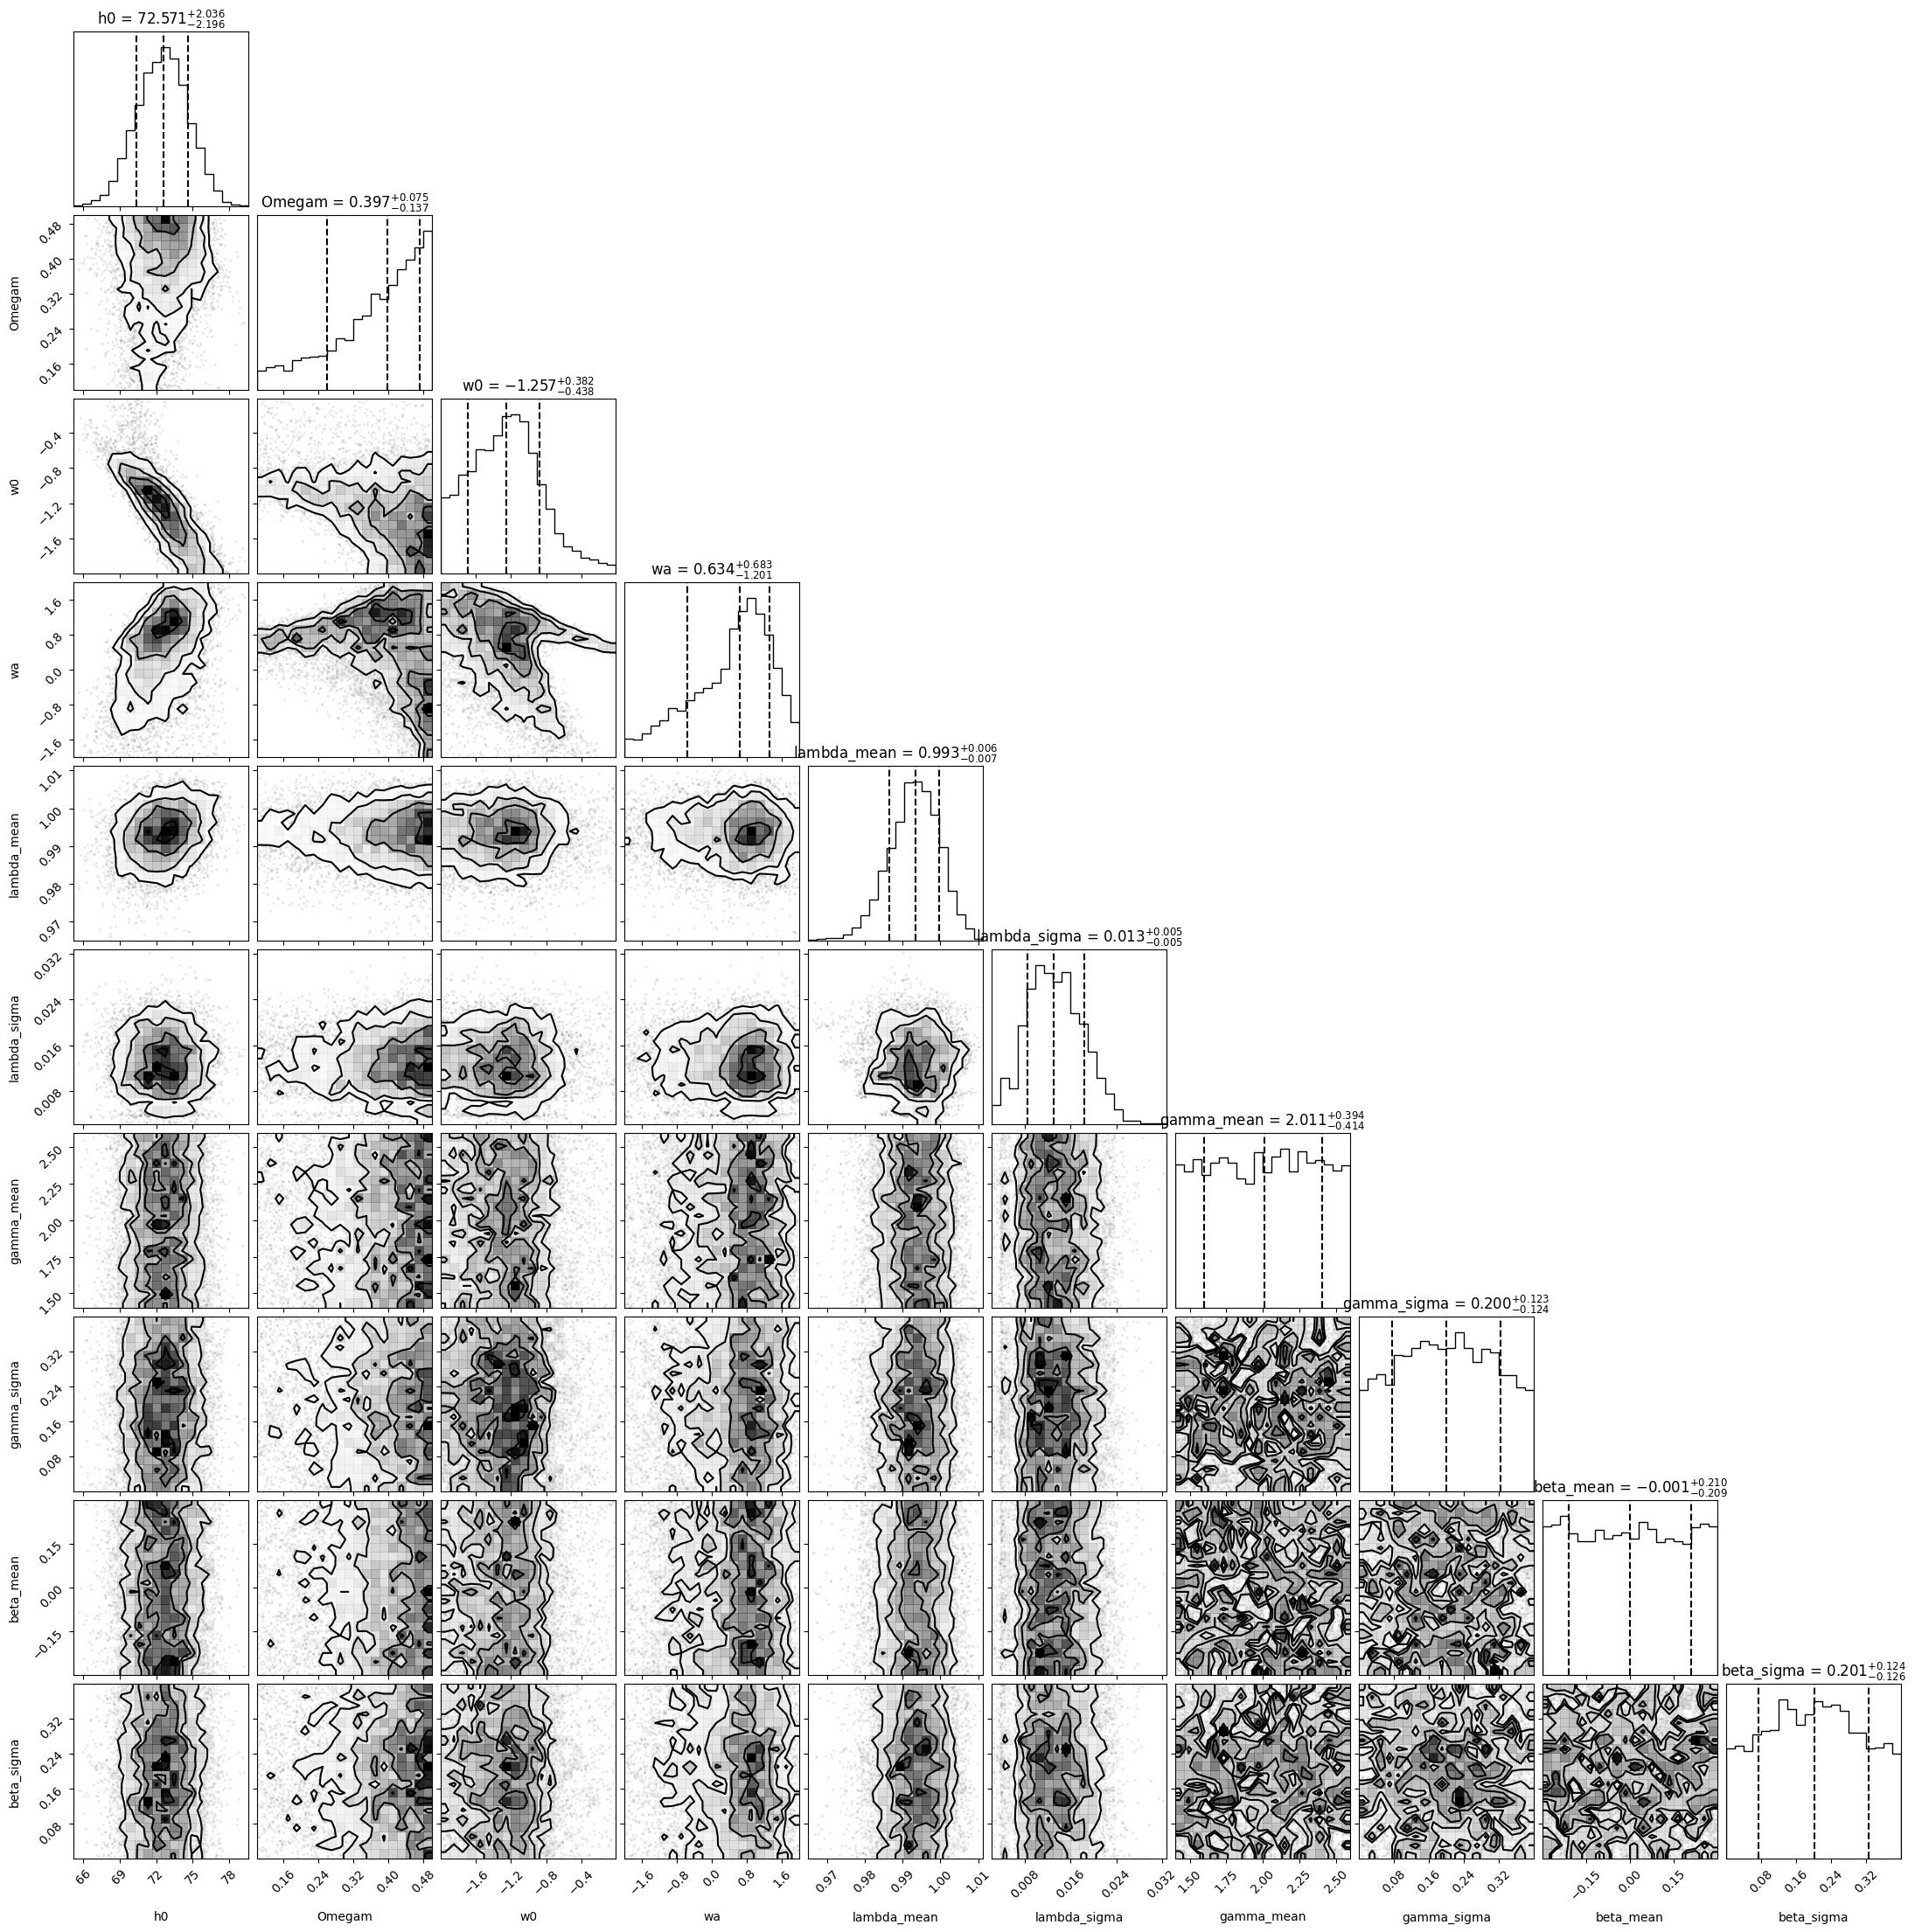

Saved: result/joint_clean_corner_from_test_notebook.pdf
Saved: result/joint_clean_corner_from_test_notebook.png


In [2]:
import arviz as az
import numpy as np
import corner
import matplotlib.pyplot as plt

preferred_vars = ['h0', 'Omegam', 'w0', 'wa', 'lambda_mean', 'lambda_sigma', 'gamma_mean', 'gamma_sigma', 'beta_mean', 'beta_sigma']
summary_vars = []
for v in preferred_vars:
    if v in idata_clean.posterior and idata_clean.posterior[v].ndim == 2:
        vals = np.asarray(idata_clean.posterior[v]).reshape(-1)
        if np.isfinite(vals).any():
            summary_vars.append(v)

# Fallback: if preferred vars are missing, use any scalar posterior variable available.
if not summary_vars:
    for v in idata_clean.posterior.data_vars:
        da = idata_clean.posterior[v]
        if da.ndim == 2 and set(da.dims) == {'chain', 'draw'}:
            vals = np.asarray(da).reshape(-1)
            if np.isfinite(vals).any():
                summary_vars.append(v)

if summary_vars:
    print(az.summary(idata_clean, var_names=summary_vars))
else:
    print('No valid scalar posterior variables found for summary/corner.')

plot_vars = summary_vars
if plot_vars:
    samples = np.column_stack([
        np.asarray(idata_clean.posterior[v]).reshape(-1)
        for v in plot_vars
    ])
    finite_mask = np.isfinite(samples).all(axis=1)
    samples = samples[finite_mask]

    fig = corner.corner(
        samples,
        labels=plot_vars,
        show_titles=True,
        title_fmt='.3f',
        quantiles=[0.16, 0.5, 0.84],
    )

    pdf_out = FIG_DIR / 'joint_clean_corner_from_test_notebook.pdf'
    png_out = FIG_DIR / 'joint_clean_corner_from_test_notebook.png'
    fig.savefig(pdf_out, dpi=200, bbox_inches='tight')
    fig.savefig(png_out, dpi=200, bbox_inches='tight')
    plt.show()

    print('Saved:', pdf_out)
    print('Saved:', png_out)
